## Proyecto 2 - Modelización

Desarrollado por David Gutiérrez & Natalia Núñez

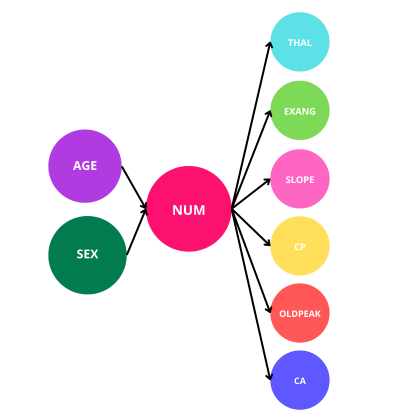

In [1]:
#Librerías
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import math
from pgmpy.inference import VariableElimination


In [2]:
#Importamos los datos como dataframe
columnas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('processed_cleveland.data', names=columnas)

In [3]:
#Convertimos datos a números

#En donde tengamos datos faltantes (?) ponemos 0

for column in df.columns:
    # Reemplazar valores "?" con 0 en la columna y fila respectivas
    df[column] = df[column].replace('?', 0)

df = df.apply(pd.to_numeric, errors='coerce')    

print(df['age'].describe())# Valor máximo 77
#print(df['oldpeak'].describe())

count    303.000000
mean      54.438944
std        9.038662
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64


Discretizar variables

In [4]:
#La variable age tiene que ser discreta para la red bayesiana, por lo que la dividiremos por cuartiles siendo 29 la edad minima y 77 la edad maxima 
df['age_discreta'] = df['age']
df.loc[df['age_discreta'] < (df['age_discreta'].describe()['25%']), 'age'] = 1
df.loc[((df['age_discreta'].describe()['25%']) <= df['age_discreta']) & (df['age_discreta'] < (df['age_discreta'].describe()['50%'])), 'age'] = 2
df.loc[((df['age_discreta'].describe()['50%']) <= df['age_discreta']) & (df['age_discreta'] < (df['age_discreta'].describe()['75%'])), 'age'] = 3
df.loc[((df['age_discreta'].describe()['75%']) <= df['age_discreta']) & (df['age_discreta'] < 77), 'age'] = 4
df.age = df.age.astype(int)

#La variable oldpeak tiene que ser discreta, por lo que la dividiremos por cuartiles siendo 0 el cuartil minimo y 6.2 el cuartil maximo
df['oldpeak_discreta'] = df['oldpeak']

df.loc[df['oldpeak_discreta'] < 0.8, 'oldpeak' ] = 1
df.loc[(0.8 <= df['oldpeak_discreta']) & (df['oldpeak_discreta'] < 1.6), 'oldpeak'] = 2
df.loc[(1.6 <= df['oldpeak_discreta']) & (df['oldpeak_discreta'] < 6.2), 'oldpeak'] = 3

df.oldpeak = df.oldpeak.astype(int)

#Variable num
df.loc[(df['num'] == 0) , 'num_discreta'] = 0
df.loc[(df['num'] != 0) , 'num_discreta'] = 1
df.num = df.num.astype(int)

#Eliminamos columnas sobrantes
df.drop(['num', 'age_discreta', 'oldpeak_discreta'], axis=1, inplace=True)
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_discreta
0,4,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,3,3.0,0.0,6.0,0.0
1,4,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,2,2.0,3.0,3.0,1.0
2,4,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,3,2.0,2.0,7.0,1.0
3,1,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3,3.0,0.0,3.0,0.0
4,1,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,2,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,2,2.0,0.0,7.0,1.0
299,4,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3,2.0,2.0,7.0,1.0
300,3,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,2,2.0,1.0,7.0,1.0
301,3,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,1,2.0,1.0,3.0,1.0


Red Bayesiana

In [5]:
#Creamos modelo
model = BayesianNetwork(
    [ ("age","num_discreta"),
     ("sex","num_discreta"),
     ("num_discreta","thal"),
     ("num_discreta","exang"),
     ("num_discreta","slope"),
     ("num_discreta","cp"),
     ("num_discreta","oldpeak"),
     ("num_discreta","ca"),

    ]

)


Maximum Likelihood

In [6]:
model.fit(
    data=df,
    estimator=MaximumLikelihoodEstimator
)
for i in model.nodes():
    print(i)
    print(model.get_cpds(i))

age
+---------+------------+
| age(1)  | 0.247525   |
+---------+------------+
| age(2)  | 0.250825   |
+---------+------------+
| age(3)  | 0.240924   |
+---------+------------+
| age(4)  | 0.257426   |
+---------+------------+
| age(77) | 0.00330033 |
+---------+------------+
num_discreta
+-------------------+-----+----------+----------+
| age               | ... | age(77)  | age(77)  |
+-------------------+-----+----------+----------+
| sex               | ... | sex(0.0) | sex(1.0) |
+-------------------+-----+----------+----------+
| num_discreta(0.0) | ... | 0.5      | 0.0      |
+-------------------+-----+----------+----------+
| num_discreta(1.0) | ... | 0.5      | 1.0      |
+-------------------+-----+----------+----------+
sex
+----------+----------+
| sex(0.0) | 0.320132 |
+----------+----------+
| sex(1.0) | 0.679868 |
+----------+----------+
thal
+--------------+----------------------+----------------------+
| num_discreta | num_discreta(0.0)    | num_discreta(1.0)    |
+--

Inferencia Bayesiana

In [7]:
# Con el fin de discretizar la variable age , utilizamos para el 25% 48 anos, para el 50% 56 anos y para el 75% 61 anos.
def discretizar_age(age):
    if age<48:
        return 1
    elif age<56:
        return 2
    elif age<61:
        return 3
    else:
        return 4

def discretizar_oldpeak(oldpeak):
    if oldpeak<0.8:
        return 1
    elif oldpeak<1.6:
        return 2
    else:
        return 3


In [20]:
def inference(evidence):
    infer=VariableElimination(model)
    prob=infer.query(variables=['num_discreta'], evidence=evidence)
    return prob.values.tolist()



[0.738295622688577, 0.26170437731142304]